# IS-4100 Lab Assignment: Exploring Poisson Regression with NFL Data

**Objective**

Use NFL play-by-play data to explore and apply Poisson regression for modeling count data. A great use case could be the number of touchdowns scored by teams during games.

**Assignment Overview**

You will work through the following key steps:

**Setup and Data Acquisition**
- Install necessary packages (e.g., `nfl_data_py` or `nflfastR`).
- Import essential libraries for data manipulation and visualization.
- Load NFL play-by-play data.


**Data Preparation and Feature Engineering**
- Compute predictor variables that may influence dependent variable.
- Create a final dataset for modeling, ensuring proper handling of missing values.

**Exploratory Data Analysis (EDA)**
- Visualize the distribution of your response variable.
- Analyze the distribution to assess suitability for Poisson regression.
- Explore relationships between predictors and the target variable.


**Modeling**
- Fit a Poisson Regression Model
- Interpret the Model
- Analyze model coefficients and their statistical significance.
- Explain the effect of each predictor on the expected number of touchdowns.

**Assess Model Fit**
- Evaluate the goodness-of-fit using appropriate metrics.
- Check for overdispersion (variance greater than the mean).


**Model Diagnostics and Refinement**
- If overdispersion is detected:
  - Fit a Negative Binomial regression model as an alternative.
  - Compare the Poisson and Negative Binomial models.
  - Determine which model better fits the data and justify your choice.

**Reporting and Conclusions**
- Summarize your findings in a clear and concise manner.
- Discuss any insights gained from the analysis.
- Reflect on the modeling process, including any challenges or limitations.
- Document your work thoroughly within the notebook, using markdown cells to explain each step.

## Setup and Data Acquisition

In [94]:
!pip install nfl_data_py

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

In [96]:
# load data
pbp = nfl.import_pbp_data(range(2016, 2023 + 1))

# display data
pbp.head()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,None,None,None,...,,,0.0,0.0,NaN,NaN,None,None,None,None
1,36.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,00-0030041;00-0030073;00-0029799;00-0030433;00...,00-0029892;00-0029895;00-0028497;00-0027539;00...,10.0,11.0,NaN,NaN,None,None,None,None
2,58.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0,11.0,NaN,NaN,None,None,None,None
3,85.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0031171;00-0029542;00-0029566;00-0030073;00...,11.0,11.0,-4.53,2.404,False,FLAT,None,None
4,109.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0,11.0,NaN,NaN,None,None,None,None


## Data Preparation and Feature Engineering

#### Features of Interest:
* Weather/precipitation
* Home/away
* Explosive rush/game
* Avg rush attempts
* Run-pass ratio
* Shotgun percentage

In [97]:
# group data by game, getting total rushing yards and attempts
pbp_run = pbp.query(
    "play_type == 'run'"
    )

# add explosive_run to dataframe
pbp_run['exp_run'] = np.where(pbp_run['yards_gained'] >= 10, 1, 0)

# add home/away
pbp_run['home'] = np.where(pbp_run['home_team'] == pbp_run['posteam'], 1, 0)

# add bad_weather
pbp_run['precip'] = np.where(pbp_run['weather'].str.contains('Rain', na = False) | pbp_run['weather'].str.contains('Snow', na = False), 1, 0)

In [98]:
# aggregate
pbp_run = pbp_run.groupby(
    ['game_id', 'season', 'week', 'posteam', 'defteam', 'weather', 'home', 'precip']
    ).agg(
        {
            'yards_gained': ['mean', 'sum'],
            'total_line': ['count'],
            'exp_run': ['sum'],
            'shotgun': ['mean'],
        }
    )


# fix column names
pbp_run.columns = list(
    map(
        "_".join, pbp_run.columns
    )
)

# rename columns
pbp_run.rename(columns = {
    'yards_gained_sum': 'total_rush_yards',
    'yards_gained_mean': 'avg_rush_yards',
    'total_line_count': 'rushes',
    'exp_run_sum': 'explos_runs',
    'shotgun_mean': 'shotgun_run_pct'
  }, inplace = True)

# reset index
pbp_run.reset_index(inplace = True)

In [99]:
# rolling average for total_rush_yards, rushes, explos_runs, and shotgun_run_pct
# total rush yards
pbp_run["rolling_avg_rush_yards"] = pbp_run.groupby('posteam')['total_rush_yards'].rolling(5).mean().shift(1).reset_index(level = 0, drop = True)

# rushes
pbp_run['rolling_avg_rushes'] = pbp_run.groupby('posteam')['rushes'].rolling(5).mean().shift(1).reset_index(level = 0, drop = True)

# explos_runs
pbp_run['rolling_avg_explos_runs'] = pbp_run.groupby('posteam')['explos_runs'].rolling(5).mean().shift(1).reset_index(level = 0, drop = True)

# shotgun_run_pct
pbp_run['rolling_avg_sh_run_pct'] = pbp_run.groupby('posteam')['shotgun_run_pct'].rolling(5).mean().shift(1).reset_index(level = 0, drop = True)

# add avg rush attempts

# display pbp_run
pbp_run.query("posteam == 'BUF'").head()

,game_id,season,week,posteam,defteam,weather,home,precip,avg_rush_yards,total_rush_yards,rushes,explos_runs,shotgun_run_pct,rolling_avg_rush_yards,rolling_avg_rushes,rolling_avg_explos_runs,rolling_avg_sh_run_pct
1,2016_01_BUF_BAL,2016,1,BUF,BAL,"Partly Cloudy Temp: 84° F, Humidity: 44%, Wind...",0,0,2.708333,65.0,24,2,0.875000,136.6,27.2,3.8,0.74
52,2016_02_NYJ_BUF,2016,2,BUF,NYJ,"Partly Cloudy Temp: 60° F, Humidity: 65%, Wind...",1,0,4.526316,86.0,19,4,0.789474,NaN,NaN,NaN,NaN
65,2016_03_ARI_BUF,2016,3,BUF,ARI,"Sunny Temp: 64° F, Humidity: 44%, Wind: NNE 8 mph",1,0,7.033333,211.0,30,6,0.533333,NaN,NaN,NaN,NaN
96,2016_04_BUF_NE,2016,4,BUF,NE,"Cloudy Temp: 56° F, Humidity: 91%, Wind: NNE 7...",0,0,4.187500,134.0,32,3,0.531250,NaN,NaN,NaN,NaN
130,2016_05_BUF_LA,2016,5,BUF,LA,"Sunny Temp: 91° F, Humidity: 18%, Wind: SW 5 m...",0,0,7.461538,194.0,26,6,0.692308,NaN,NaN,NaN,NaN


In [100]:
# add run/pass ratio
run_pass_ratio_df = pbp.groupby(
    ['game_id', 'season', 'week', 'posteam', 'defteam']
).agg(
    {
        'rush_attempt': ['sum'],
        'pass_attempt': ['sum']
    }
)

# fix column names
run_pass_ratio_df.columns = list(
    map(
        "_".join, run_pass_ratio_df.columns
    )
)

# add run_pass_ratio column
run_pass_ratio_df['rp_ratio'] = run_pass_ratio_df['rush_attempt_sum'] / run_pass_ratio_df['pass_attempt_sum']

# lots of missing data from 2021 NE vs. BUF causes erroneous calculations
run_pass_ratio_df.query("rp_ratio > 10")

# filter out
run_pass_ratio_df = run_pass_ratio_df[run_pass_ratio_df['rp_ratio'] < 15]

In [101]:
# drop 2021 NE vs. BUF from pbp_run
pbp_run = pbp_run[pbp_run['game_id'] != '2021_13_NE_BUF']

# merge pbp_run and run/pass ratio
pbp_run = pbp_run.merge(
    run_pass_ratio_df,
    on = ['game_id', 'posteam'],
    how = 'left'
)

# drop weather
pbp_run.drop(columns = 'weather', inplace = True)

# display dataframe
pbp_run.head()

,game_id,season,week,posteam,defteam,home,precip,avg_rush_yards,total_rush_yards,rushes,explos_runs,shotgun_run_pct,rolling_avg_rush_yards,rolling_avg_rushes,rolling_avg_explos_runs,rolling_avg_sh_run_pct,rush_attempt_sum,pass_attempt_sum,rp_ratio
0,2016_01_BUF_BAL,2016,1,BAL,BUF,1,0,3.440000,86.0,25,2,0.520000,107.6,27.0,2.4,0.798333,28.0,37.0,0.756757
1,2016_01_BUF_BAL,2016,1,BUF,BAL,0,0,2.708333,65.0,24,2,0.875000,136.6,27.2,3.8,0.740000,24.0,24.0,1.000000
2,2016_01_CAR_DEN,2016,1,CAR,DEN,0,0,4.906250,157.0,32,3,0.625000,145.6,34.2,3.2,0.469955,32.0,36.0,0.888889
3,2016_01_CAR_DEN,2016,1,DEN,CAR,1,0,5.555555,150.0,27,6,0.111111,100.4,23.6,2.0,0.403990,29.0,28.0,1.035714
4,2016_01_CHI_HOU,2016,1,CHI,HOU,0,0,3.650000,73.0,20,2,0.050000,124.4,28.4,4.2,0.359625,20.0,34.0,0.588235


In [102]:
# add rolling average for rp_ratio
pbp_run['rolling_avg_rp_ratio'] = pbp_run.groupby('posteam')['rp_ratio'].rolling(5).mean().shift(1).reset_index(level = 0, drop = True)

# display dataframe
pbp_run.head()

,game_id,season,week,posteam,defteam,home,precip,avg_rush_yards,total_rush_yards,rushes,explos_runs,shotgun_run_pct,rolling_avg_rush_yards,rolling_avg_rushes,rolling_avg_explos_runs,rolling_avg_sh_run_pct,rush_attempt_sum,pass_attempt_sum,rp_ratio,rolling_avg_rp_ratio
0,2016_01_BUF_BAL,2016,1,BAL,BUF,1,0,3.440000,86.0,25,2,0.520000,107.6,27.0,2.4,0.798333,28.0,37.0,0.756757,0.884652
1,2016_01_BUF_BAL,2016,1,BUF,BAL,0,0,2.708333,65.0,24,2,0.875000,136.6,27.2,3.8,0.740000,24.0,24.0,1.000000,0.989100
2,2016_01_CAR_DEN,2016,1,CAR,DEN,0,0,4.906250,157.0,32,3,0.625000,145.6,34.2,3.2,0.469955,32.0,36.0,0.888889,1.099547
3,2016_01_CAR_DEN,2016,1,DEN,CAR,1,0,5.555555,150.0,27,6,0.111111,100.4,23.6,2.0,0.403990,29.0,28.0,1.035714,0.613500
4,2016_01_CHI_HOU,2016,1,CHI,HOU,0,0,3.650000,73.0,20,2,0.050000,124.4,28.4,4.2,0.359625,20.0,34.0,0.588235,0.953647


## Exploratory Data Analysis (EDA)

### Effect of Precipitation

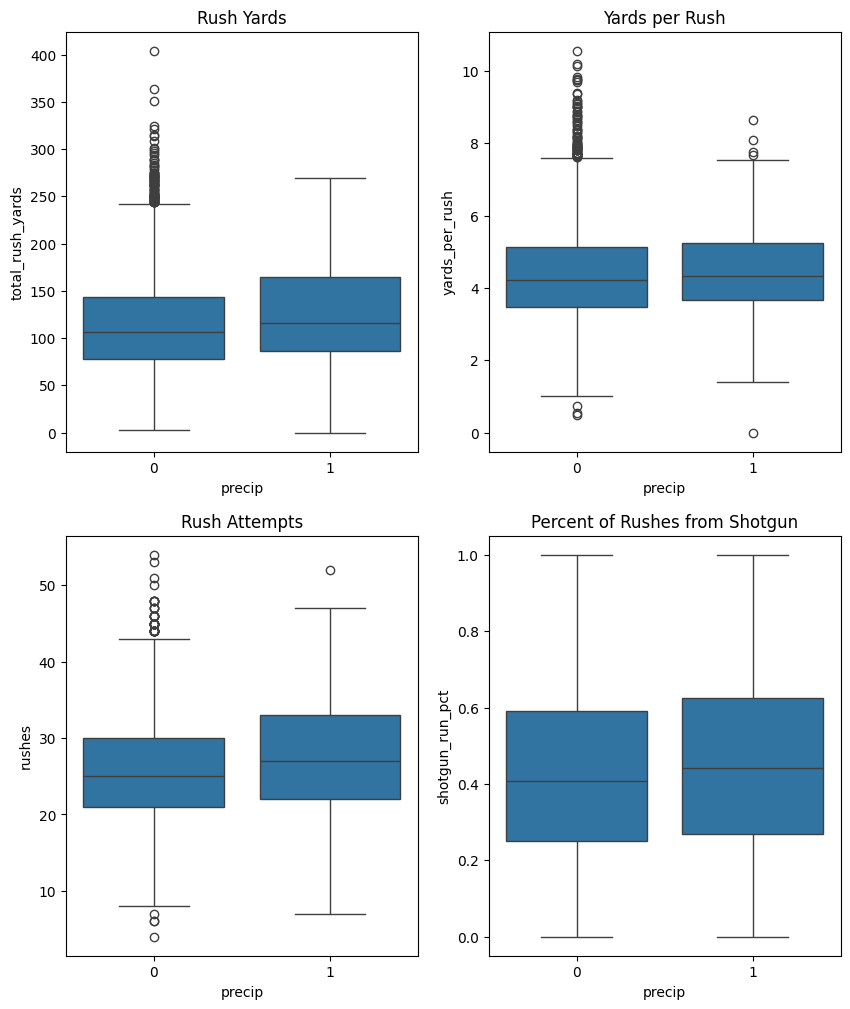

In [103]:
# subplots 2x2
fig, axs = plt.subplots(2, 2, figsize = (10, 12))

# box plot of rush yards by precipitation
sns.boxplot(data = pbp_run, x = 'precip', y = 'total_rush_yards', ax = axs[0][0])
axs[0][0].set_title("Rush Yards")

# box plot of average rush yards by precipitation
sns.boxplot(data = pbp_run, x = 'precip', y ='avg_rush_yards', ax = axs[0][1])
axs[0][1].set_title("Yards per Rush")
axs[0][1].set_ylabel("yards_per_rush")

# box plot of average rush attempts by precipitation
sns.boxplot(data = pbp_run, x = 'precip', y = 'rushes', ax = axs[1][0])
axs[1][0].set_title("Rush Attempts")

# boxplot of shotgun rushes by precipitation
sns.boxplot(data = pbp_run, x = 'precip', y = 'shotgun_run_pct', ax = axs[1][1])
axs[1][1].set_title("Percent of Rushes from Shotgun")
plt.show()

### Effect of Home/Away and Run-Pass Ratio

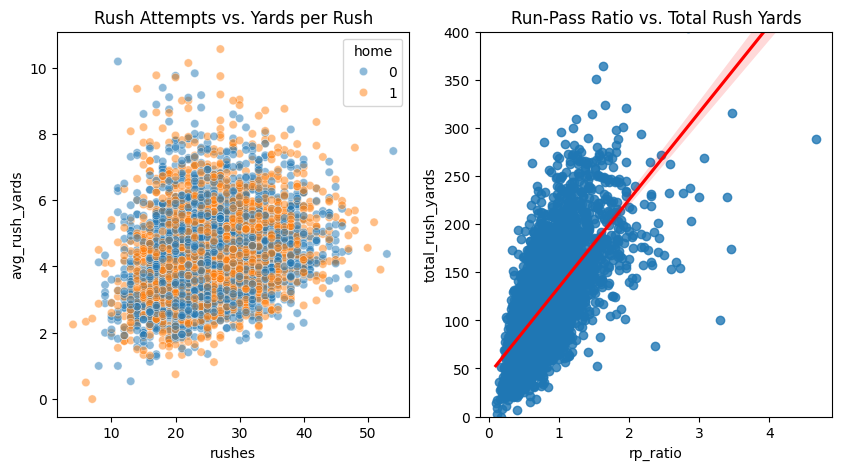

In [104]:
# subplots 1x2
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# rush attempts by yards/rush, color by home/away (no pattern)
sns.scatterplot(data = pbp_run, x = 'rushes', y = 'avg_rush_yards', hue = 'home', alpha = 0.5, ax = axs[0])
axs[0].set_title("Rush Attempts vs. Yards per Rush")

# rush yards by run-pass ratio - positive correlation
sns.regplot(data = pbp_run, x = 'rp_ratio', y = 'total_rush_yards', line_kws = {'color': 'red'}, ax = axs[1])
axs[1].set_title("Run-Pass Ratio vs. Total Rush Yards")
axs[1].set_ylim(0, 400)


plt.show()

### Effect of Explosive Rushes

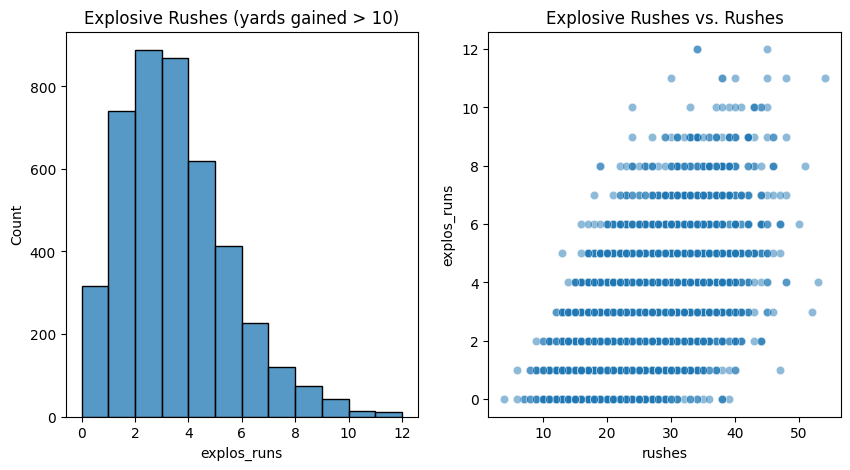

In [105]:
# subplots 1x2
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# histogram of counts of explosive runs
sns.histplot(data = pbp_run, x = 'explos_runs', binwidth = 1, ax = axs[0])
axs[0].set_title("Explosive Rushes (yards gained > 10)")


# scatterplot of explosive runs by rushes
sns.scatterplot(data = pbp_run, x = 'rushes', y = 'explos_runs', alpha = 0.5, ax = axs[1])
axs[1].set_title("Explosive Rushes vs. Rushes")

plt.show()

### Probability Distribution

In [106]:
# round total_rush_yards to nearest 10 for binning
pbp_run['rush_yards_10'] = round(pbp_run['total_rush_yards'], -1)

In [107]:
# calculate mean rush yards for poisson
rush_yards_mean = pbp_run['total_rush_yards'].mean()

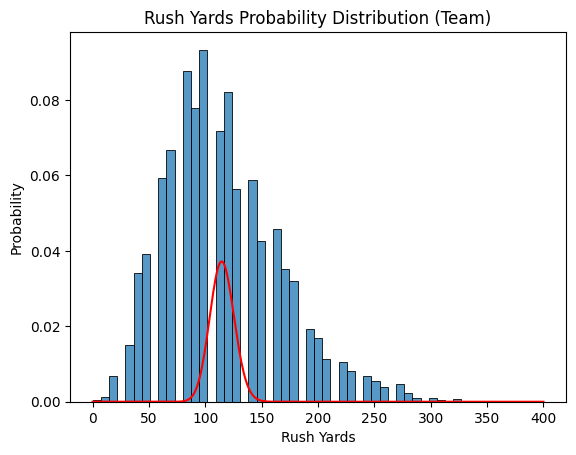

In [108]:
# histogram plot with probability

plot_pos = pd.DataFrame(
    {
        'x': range(0,int(max(pbp_run['rush_yards_10'] + 1))),
        'expected': [poisson.pmf(x, rush_yards_mean) for x in range(0,int(max(pbp_run['rush_yards_10'] + 1)))]
    }
)

# histogram
sns.histplot(data = pbp_run["rush_yards_10"], stat = "probability")
plt.xlabel("Rush Yards")
plt.title("Rush Yards Probability Distribution (Team)")

# Add expected line
plt.plot(plot_pos['x'], plot_pos['expected'], color = 'red')

# show plot
plt.show()

## Modeling

#### Rolling Averages for Inputs

In [109]:
# fit poisson model
poisson_fit_rolling = smf.glm(
    formula = "rush_yards_10 ~ home + precip + rolling_avg_rp_ratio + rolling_avg_sh_run_pct + rolling_avg_rush_yards + rolling_avg_rushes + rolling_avg_explos_runs",
    data = pbp_run,
    family = sm.families.Poisson()
).fit()

In [110]:
# predict with model (expected rush yards)
pbp_run['expected_rush_yards_rolling'] = poisson_fit_rolling.predict(pbp_run)

# print model summary
poisson_fit_rolling.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          rush_yards_10   No. Observations:                 4199
Model:                            GLM   Df Residuals:                     4191
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58646.
Date:                Thu, 24 Oct 2024   Deviance:                       90090.
Time:                        19:21:47   Pearson chi2:                 9.11e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7192
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.4498      0.012    382.962      0.000       4.427       4.473
home                        0.0473      0.003     16.452      0.000       0.042       0.053
precip                      0.0647      0.006     10.712      0.000       0.053       0.077
rolling_avg_rp_ratio        0.3363      0.013     26.871      0.000       0.312       0.361
rolling_avg_sh_run_pct      0.1542      0.007     20.926      0.000       0.140       0.169
rolling_avg_rush_yards      0.0021      0.000     15.178      0.000       0.002       0.002
rolling_avg_rushes         -0.0128      0.001    -15.885      0.000      -0.014      -0.011
rolling_avg_explos_runs     0.0085      0.003      3.182      0.001       0.003       0.014
===========================================================================================
"""

In [111]:
# exponentiate coefficients to get odds
odds_rolling = np.exp(poisson_fit_rolling.params)

# view odds
odds_rolling.sort_values(ascending = False)

,0
Intercept,85.607472
rolling_avg_rp_ratio,1.399796
rolling_avg_sh_run_pct,1.166747
precip,1.066834
home,1.048453
rolling_avg_explos_runs,1.008487
rolling_avg_rush_yards,1.002078
rolling_avg_rushes,0.987275


#### Normal Values for Inputs

In [112]:
# fit poisson model
poisson_fit_static = smf.glm(
    formula = "rush_yards_10 ~ home + precip + rp_ratio + shotgun_run_pct + rushes + explos_runs",
    data = pbp_run,
    family = sm.families.Poisson()
).fit()

In [113]:
# predict with model (expected rush yards)
pbp_run['expected_rush_yards_static'] = poisson_fit_static.predict(pbp_run)

# print model summary
poisson_fit_static.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          rush_yards_10   No. Observations:                 4328
Model:                            GLM   Df Residuals:                     4321
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25404.
Date:                Thu, 24 Oct 2024   Deviance:                       22781.
Time:                        19:21:47   Pearson chi2:                 2.27e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6242      0.007    542.974      0.000       3.611       3.637
home                0.0004      0.003      0.134      0.893      -0.005       0.006
precip             -0.0147      0.006     -2.463      0.014      -0.026      -0.003
rp_ratio            0.0071      0.005      1.292      0.196      -0.004       0.018
shotgun_run_pct     0.0171      0.006      2.854      0.004       0.005       0.029
rushes              0.0282      0.000     84.050      0.000       0.028       0.029
explos_runs         0.1030      0.001    136.839      0.000       0.101       0.104
===================================================================================
"""

In [114]:
# exponentiate coefficients to get odds
odds_static = np.exp(poisson_fit_static.params)

# view odds
odds_static.sort_values(ascending = False)

,0
Intercept,37.494420
explos_runs,1.108440
rushes,1.028567
shotgun_run_pct,1.017284
rp_ratio,1.007098
home,1.000382
precip,0.985375


### PMF and CDF

In [115]:
# PMF and CDF

# with so many possible values, PMF is not going to tell us much.
# CDF will be more useful

# "rolling" predictors
pbp_run["pmf_rolling"] = poisson.pmf(
    k = 100, mu = pbp_run["expected_rush_yards_rolling"]
)

# "static" predictors
pbp_run["pmf_static"] = poisson.pmf(
    k = 100, mu = pbp_run["expected_rush_yards_static"]
)


pbp_run.head()

,game_id,season,week,posteam,defteam,home,precip,avg_rush_yards,total_rush_yards,rushes,...,rolling_avg_sh_run_pct,rush_attempt_sum,pass_attempt_sum,rp_ratio,rolling_avg_rp_ratio,rush_yards_10,expected_rush_yards_rolling,expected_rush_yards_static,pmf_rolling,pmf_static
0,2016_01_BUF_BAL,2016,1,BAL,BUF,1,0,3.440000,86.0,25,...,0.798333,28.0,37.0,0.756757,0.884652,90.0,123.425947,94.529675,0.003693,0.034127
1,2016_01_BUF_BAL,2016,1,BUF,BAL,0,0,2.708333,65.0,24,...,0.740000,24.0,24.0,1.000000,0.989100,60.0,129.532877,92.588870,0.001029,0.029857
2,2016_01_CAR_DEN,2016,1,CAR,DEN,0,0,4.906250,157.0,32,...,0.469955,32.0,36.0,0.888889,1.099547,160.0,119.510622,127.917618,0.007376,0.001476
3,2016_01_CAR_DEN,2016,1,DEN,CAR,1,0,5.555555,150.0,27,...,0.403990,29.0,28.0,1.035714,0.613500,150.0,108.727322,150.209014,0.027809,0.000003
4,2016_01_CHI_HOU,2016,1,CHI,HOU,0,0,3.650000,73.0,20,...,0.359625,20.0,34.0,0.588235,0.953647,70.0,116.283806,81.324867,0.012037,0.005412


In [116]:
# cdf (100+ yards rushing)

# cdf 100 - rolling
pbp_run["cdf_rolling_100"] = 1 - poisson.cdf(
    k = 100, mu = pbp_run["expected_rush_yards_rolling"]
)

# cdf 100 -static
pbp_run["cdf_static_100"] = 1 - poisson.cdf(
    k = 100, mu = pbp_run["expected_rush_yards_static"]
)

pbp_run

,game_id,season,week,posteam,defteam,home,precip,avg_rush_yards,total_rush_yards,rushes,...,pass_attempt_sum,rp_ratio,rolling_avg_rp_ratio,rush_yards_10,expected_rush_yards_rolling,expected_rush_yards_static,pmf_rolling,pmf_static,cdf_rolling_100,cdf_static_100
0,2016_01_BUF_BAL,2016,1,BAL,BUF,1,0,3.440000,86.0,25,...,37.0,0.756757,0.884652,90.0,123.425947,94.529675,0.003693,0.034127,0.982890,0.266067
1,2016_01_BUF_BAL,2016,1,BUF,BAL,0,0,2.708333,65.0,24,...,24.0,1.000000,0.989100,60.0,129.532877,92.588870,0.001029,0.029857,0.995869,0.203847
2,2016_01_CAR_DEN,2016,1,CAR,DEN,0,0,4.906250,157.0,32,...,36.0,0.888889,1.099547,160.0,119.510622,127.917618,0.007376,0.001476,0.961864,0.993864
3,2016_01_CAR_DEN,2016,1,DEN,CAR,1,0,5.555555,150.0,27,...,28.0,1.035714,0.613500,150.0,108.727322,150.209014,0.027809,0.000003,0.783213,0.999992
4,2016_01_CHI_HOU,2016,1,CHI,HOU,0,0,3.650000,73.0,20,...,34.0,0.588235,0.953647,70.0,116.283806,81.324867,0.012037,0.005412,0.930962,0.019326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,2023_21_DET_SF,2023,21,SF,DET,1,0,5.129032,159.0,31,...,33.0,1.000000,0.846680,160.0,126.143299,137.222828,0.002153,0.000150,0.990677,0.999478
4324,2023_21_KC_BAL,2023,21,BAL,KC,1,0,5.466667,82.0,15,...,41.0,0.390244,1.222163,80.0,147.292929,79.324577,0.000008,0.003315,0.999977,0.010723
4325,2023_21_KC_BAL,2023,21,KC,BAL,0,0,3.172414,92.0,29,...,41.0,0.780488,0.799171,90.0,120.602704,105.775540,0.006146,0.033946,0.969232,0.691794
4326,2023_22_SF_KC,2023,22,KC,SF,1,0,4.333333,130.0,30,...,49.0,0.612245,0.853227,130.0,127.184627,121.013959,0.001729,0.005726,0.992692,0.971673


In [117]:
# cdf for ranges

# 70 - 90 yards
pbp_run["cdf_70_90_static"] = poisson.cdf(
    k = 90, mu = pbp_run["expected_rush_yards_static"]) - poisson.cdf(
        k = 70, mu = pbp_run["expected_rush_yards_static"]
    )

# 90 - 110 yards
pbp_run["cdf_90_110_static"] = poisson.cdf(
    k = 110, mu = pbp_run["expected_rush_yards_static"]) - poisson.cdf(
        k = 90, mu = pbp_run["expected_rush_yards_static"]
    )

# 110 - 130 yards
pbp_run["cdf_110_130_static"] = poisson.cdf(
    k = 130, mu = pbp_run["expected_rush_yards_static"]) - poisson.cdf(
        k = 110, mu = pbp_run["expected_rush_yards_static"]
    )

# 150+ yards
pbp_run["cdf_130+_static"] = 1 - poisson.cdf(
    k = 130, mu = pbp_run["expected_rush_yards_static"])

pbp_run[["total_rush_yards","expected_rush_yards_rolling","expected_rush_yards_static","cdf_70_90_static", "cdf_90_110_static", "cdf_110_130_static", "cdf_130+_static"]]

,total_rush_yards,expected_rush_yards_rolling,expected_rush_yards_static,cdf_70_90_static,cdf_90_110_static,cdf_110_130_static,cdf_130+_static
0,86.0,123.425947,94.529675,3.394473e-01,0.602441,0.052822,2.222817e-04
1,65.0,129.532877,92.588870,4.118701e-01,0.545274,0.034084,9.766837e-05
2,157.0,119.510622,127.917618,2.529122e-04,0.058891,0.536568,4.042877e-01
3,150.0,108.727322,150.209014,7.636444e-08,0.000353,0.051047,9.486001e-01
4,73.0,116.283806,81.324867,7.322874e-01,0.153480,0.001023,2.514302e-07
...,...,...,...,...,...,...,...
4323,159.0,126.143299,137.222828,1.119637e-05,0.009445,0.276810,7.137347e-01
4324,82.0,147.292929,79.324577,7.326270e-01,0.106074,0.000450,6.860402e-08
4325,92.0,120.602704,105.775540,6.580400e-02,0.615635,0.308627,9.795690e-03
4326,130.0,127.184627,121.013959,1.933194e-03,0.167924,0.637001,1.931417e-01


In [118]:
# remove scientific notation
pbp_run_rounded = round(pbp_run, 5)

# display values
pbp_run_rounded[["total_rush_yards","expected_rush_yards_static","cdf_70_90_static", "cdf_90_110_static", "cdf_110_130_static", "cdf_130+_static"]]

,total_rush_yards,expected_rush_yards_static,cdf_70_90_static,cdf_90_110_static,cdf_110_130_static,cdf_130+_static
0,86.0,94.52968,0.33945,0.60244,0.05282,0.00022
1,65.0,92.58887,0.41187,0.54527,0.03408,0.00010
2,157.0,127.91762,0.00025,0.05889,0.53657,0.40429
3,150.0,150.20901,0.00000,0.00035,0.05105,0.94860
4,73.0,81.32487,0.73229,0.15348,0.00102,0.00000
...,...,...,...,...,...,...
4323,159.0,137.22283,0.00001,0.00944,0.27681,0.71373
4324,82.0,79.32458,0.73263,0.10607,0.00045,0.00000
4325,92.0,105.77554,0.06580,0.61563,0.30863,0.00980
4326,130.0,121.01396,0.00193,0.16792,0.63700,0.19314


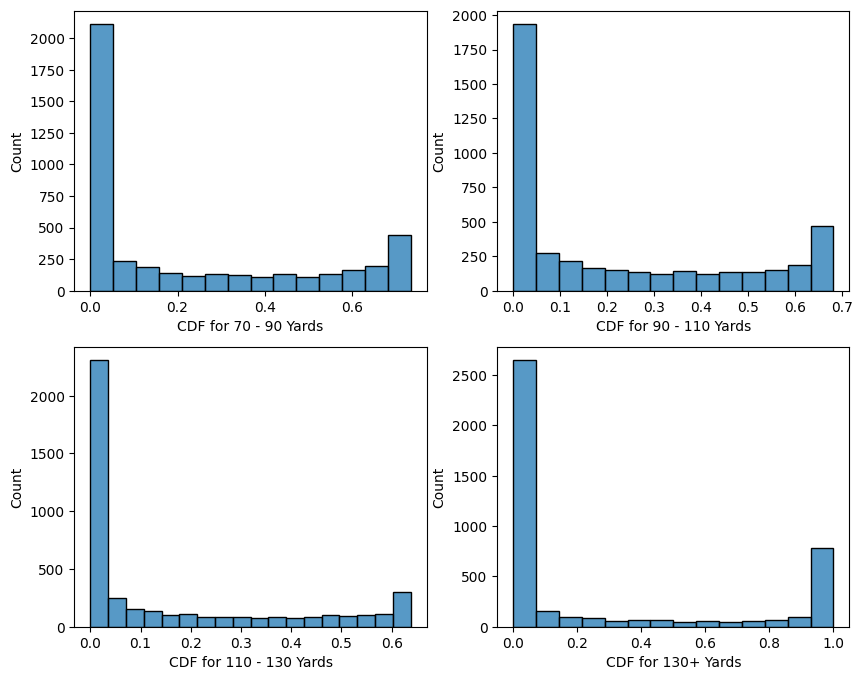

In [119]:
# subplot (2x2) of counts of cdf values for each range

fix, axs = plt.subplots(2, 2, figsize = (10, 8))

# histogram for cdfs between 70 and 90 yards
sns.histplot(data = pbp_run_rounded, x = 'cdf_70_90_static', stat = 'count', ax = axs[0][0])
axs[0][0].set_xlabel("CDF for 70 - 90 Yards")

# histogram for cdfs between 90 and 110 yards
sns.histplot(data = pbp_run_rounded, x = 'cdf_90_110_static', stat = 'count', ax = axs[0][1])
axs[0][1].set_xlabel("CDF for 90 - 110 Yards")

# histogram for cdfs between 110 and 130 yards
sns.histplot(data = pbp_run_rounded, x = 'cdf_110_130_static', stat = 'count', ax = axs[1][0])
axs[1][0].set_xlabel("CDF for 110 - 130 Yards")

# histogram for cdfs of 130+ yards
sns.histplot(data = pbp_run_rounded, x = 'cdf_130+_static', stat = 'count', ax = axs[1][1])
axs[1][1].set_xlabel("CDF for 130+ Yards")

plt.show()

## Assess Model Fit

### Goodness of fit

In [120]:
# print r values for both models
print(f"R-squared (rolling vars): {round(poisson_fit_rolling.pseudo_rsquared(), 3)}")
print(f"R-squared (static vars): {round(poisson_fit_static.pseudo_rsquared(), 3)}")

R-squared (rolling vars): 0.719
R-squared (static vars): 1.0


### Accuracy

In [121]:
# rolling model

# drop na
pbp_run = pbp_run.dropna()

# mean squared error
mse_rolling = mean_squared_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_rolling'])

# root mean squared error
rmse_rolling = np.sqrt(mse_rolling)

# mean absolute error
mae_rolling = mean_absolute_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_rolling'])

print(f"MSE: {round(mse_rolling, 2)}\nRMSE: {round(rmse_rolling, 2)}")
print(f"MAE: {round(mae_rolling, 2)}")

MSE: 2511.1
RMSE: 50.11
MAE: 39.41


In [122]:
# static model

# mean squared error
mse_static = mean_squared_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_static'])

# root mean squared error
rmse_static = np.sqrt(mse_static)

# mean absolute error
mae_static = mean_absolute_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_static'])

print(f"MSE: {round(mse_static, 2)}\nRMSE: {round(rmse_static, 2)}")
print(f"MAE: {round(mae_static, 2)}")

MSE: 641.85
RMSE: 25.33
MAE: 18.43


### Check for Overdispersion

In [123]:
mean = round(pbp_run['expected_rush_yards_static'].mean(), 3)
variance = round(pbp_run['expected_rush_yards_static'].var(), 3)

if variance > mean:
    print(f"{variance} > {mean}\nOverdispersed")
else:
    print(f"{variance} < {mean}\nUnderdispersed")

2346.942 > 115.302
Overdispersed


## Model Diagnostics and Refinement

If overdispersion is detected:

Fit a Negative Binomial regression model as an alternative.
Compare the Poisson and Negative Binomial models.
Determine which model better fits the data and justify your choice.

In [124]:
# fit negative binomial regression model
# fit poisson model
neg_binomial_static = smf.glm(
    formula = "rush_yards_10 ~ home + precip + rp_ratio + shotgun_run_pct + rushes + explos_runs",
    data = pbp_run,
    family = sm.families.NegativeBinomial()
).fit()

In [125]:
# predict with model (expected rush yards)
pbp_run['expected_rush_yards_nb_static'] = neg_binomial_static.predict(pbp_run)

# print model summary
neg_binomial_static.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          rush_yards_10   No. Observations:                 4199
Model:                            GLM   Df Residuals:                     4192
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23820.
Date:                Thu, 24 Oct 2024   Deviance:                       238.37
Time:                        19:21:50   Pearson chi2:                     217.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1471
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4607      0.071     48.513      0.000       3.321       3.601
home               -0.0018      0.031     -0.057      0.955      -0.063       0.059
precip             -0.0138      0.068     -0.204      0.839      -0.147       0.119
rp_ratio           -0.0022      0.070     -0.032      0.975      -0.140       0.135
shotgun_run_pct     0.0411      0.067      0.610      0.542      -0.091       0.173
rushes              0.0325      0.004      8.335      0.000       0.025       0.040
explos_runs         0.1166      0.009     12.768      0.000       0.099       0.135
===================================================================================
"""

### Metrics

In [126]:
# r-value
print(f"R-squared: {round(neg_binomial_static.pseudo_rsquared(), 3)}")

R-squared: 0.147


In [127]:
# accuracy metrics
# mean squared error
mse_static = mean_squared_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_nb_static'])

# root mean squared error
rmse_static = np.sqrt(mse_static)

# mean absolute error
mae_static = mean_absolute_error(pbp_run['total_rush_yards'], pbp_run['expected_rush_yards_nb_static'])

print(f"MSE: {round(mse_static, 2)}\nRMSE: {round(rmse_static, 2)}")
print(f"MAE: {round(mae_static, 2)}")

MSE: 832.73
RMSE: 28.86
MAE: 19.48


The poisson model better fits the data better because it has a better r-squared value (0.999 vs. 0.147) and it has a better RMSE and MAE (25.33 and 18.43 compared to 28.86 and 19.48).

## Reporting and Conclusions

Summarize your findings in a clear and concise manner.
Discuss any insights gained from the analysis.
Reflect on the modeling process, including any challenges or limitations.
Document your work thoroughly within the notebook, using markdown cells to explain each step.

**Findings**

The poisson model, despite being overdispersed turned out to be the better model, given its higher **r-squared** value and lower **root mean squared error** and **mean absolute error**.  Its p-value was extremely high (about 1) which means the almost all the variance in the data can be accounted for by the model.

I also found that the poisson model was more accurate using static data (actual values from the game) rather than rolling average values.

**Challenges and Limitations**

The biggest challenge in this project was the data engineering step because I had to figure out how to do the rolling averages for each of my columns, shiftiing their values to not include themselves, and then re-index them.